In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
from matplotlib.animation import FuncAnimation
from functools import partial

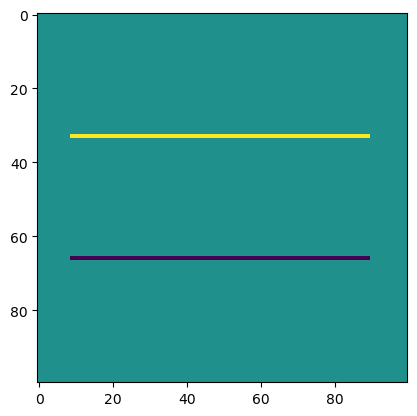

In [55]:
n = 100     #formerly grid_size
grid = np.zeros([n, n], dtype=int)

separation_factor = 2/3     # horizontal separation of the plates
vertical_aspect = 0.8   # amount of vertical grid_size taken up by plate

y1 = int(0.5*n*(1 - vertical_aspect))
y2 = int(0.5*n*(1 + vertical_aspect))
assert 0 <= separation_factor <= 1
assert 0 <= vertical_aspect <= 1
offset = int(separation_factor * (n//2))
grid[y1:y2, offset] = 1
grid[y1:y2, n-offset-1] = -1
plt.imshow(grid.T, cmap='viridis')
plt.show()

In [56]:
diags = np.array([np.ones(n*n) * -4, np.ones(n*n), np.ones(n*n), np.ones(n*n), np.ones(n*n)])
laplacian = sps.spdiags(diags, [0, 1, -1, n, -n], n*n, n*n)
b = sps.csr_matrix(grid.flatten().astype(float)).reshape(-1, 1) # FAST sparsemat conversion
A = laplacian.copy().tocsc()
x = sps.linalg.spsolve(A, b) # solving the laplacian

In [57]:
potential = x.reshape(100, 100)
levels_pos = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1]) # determine levels to be shown for each "eye" on the contour plot
levels_neg = np.flip(levels_pos) * -1
levels = np.hstack([levels_neg, levels_pos]) * potential.max()

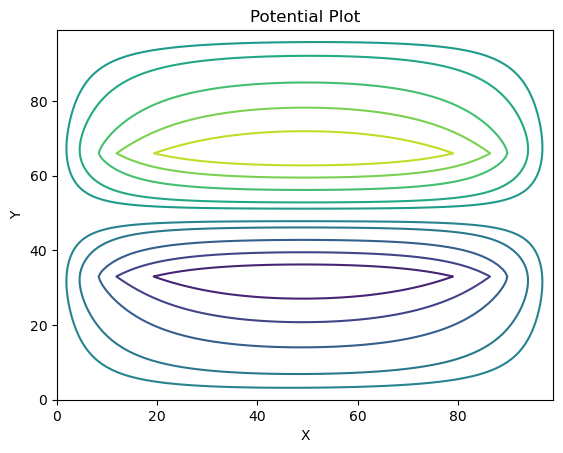

In [58]:
plt.contour(potential.T, cmap='viridis', levels=levels)
plt.title('Potential Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [59]:
def get_col_gradient(arr):
    assert arr.ndim == 2
    n = len(arr.T)
    grad = (np.pad(arr, ((0, 0), (0, 2))) - np.pad(arr, ((0, 0), (2, 0))))/2
    grad = grad[:, 1:n+1]
    fw_diff = arr[:, 1] - arr[:, 0]
    bw_diff = arr[:, n-1] - arr[:, n-2]
    grad[:, 0] = fw_diff
    grad[:, n-1] = bw_diff
    return grad

def get_row_gradient(arr):
    assert arr.ndim == 2
    n = len(arr)  # Now working with rows instead of columns
    grad = (np.pad(arr, ((0, 2), (0, 0))) - np.pad(arr, ((2, 0), (0, 0))))/2
    grad = grad[1:n+1, :]
    fw_diff = arr[1, :] - arr[0, :]
    bw_diff = arr[n-1, :] - arr[n-2, :]
    grad[0, :] = fw_diff
    grad[n-1, :] = bw_diff
    return grad

def gradient(arr):
    return (get_row_gradient(arr), get_col_gradient(arr))

field = gradient(potential)

In [60]:
P = 12

# particles get field with continuous location
class Particle:
    def __init__(self):
        self.x = np.random.normal(n/2, 10)
        self.y = np.random.normal(n/2, 10)
        self.Ux = field[0][int(self.x), int(self.y)]
        self.Uy = field[1][int(self.x), int(self.y)]

    def move(self):
        self.x += self.Ux
        self.y += self.Uy

    def plot(self, axesObject):
        axesObject.plot(self.x, self.y, color='yellow', marker='o')

# P particles in frame per timestep
class Simulation:
    def __init__(self):
        self.particles = [Particle for i in range(P)]
        self.frames = [[[],[]] for i in range(P)]

    def run(self, max_steps=150):
        for i in range(P):
            for t in range(max_steps):
                particle = Particle()
                particle.move()
                self.frames[i][0].append(particle.x)
                self.frames[i][1].append(particle.y)

sim = Simulation()
sim.run()

In [61]:
%whos

Variable                        Type             Data/Info
----------------------------------------------------------
A                               csc_matrix         (0, 0)	-4.0\n  (1, 0)	1<...>	1.0\n  (9999, 9999)	-4.0
Animation                       type             <class '__main__.Animation'>
FuncAnimation                   type             <class 'matplotlib.animation.FuncAnimation'>
P                               int              12
Particle                        type             <class '__main__.Particle'>
Simulation                      type             <class '__main__.Simulation'>
a                               FuncAnimation    <matplotlib.animation.Fun<...>ct at 0x0000020FBF01DF10>
animation                       Animation        <__main__.Animation object at 0x0000020FBF092DB0>
ax                              Axes             Axes(0.125,0.11;0.775x0.77)
b                               coo_matrix         (933, 0)	1.0\n  (966, 0<...> 0)	1.0\n  (8966, 0)	-1.0
diags      

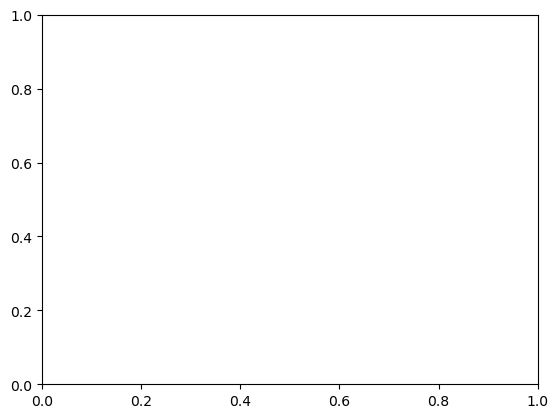

In [62]:
class Animation():
    def __init__(self):
        self.time = 0

    def static_plot(self):
        contour_plot = plt.contour(potential.T, cmap='viridis', levels=levels) # static contour plot
        ax.set_title('Particle Plot')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        return contour_plot.axes.get_children()

    def update(self, frames, axesObject):
        artists = []
        t = self.time
        snapshot = frames[t]
        for particle_location in snapshot:
            artists.append(plt.scatter(particle_location[0], particle_location[1]))
        t += 1
        if t >= len(frames):
            print('Animation complete!')
        else:
            print('Continuing the animation!')
        return artists

animation = Animation()
fig, ax = plt.subplots()
func = partial(animation.update, frames=sim.frames, axesObject=ax)

Continuing the animation!


2

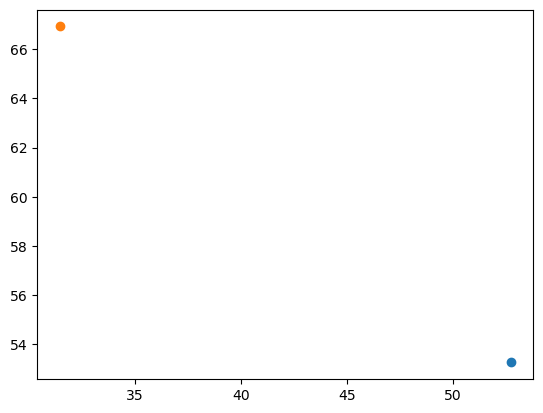

In [63]:
len(func())

C:\Users\jaspe\AppData\Local\Temp\ipykernel_6096\2167020789.py:1: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  a = FuncAnimation(fig, func, init_func=animation.static_plot)
MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

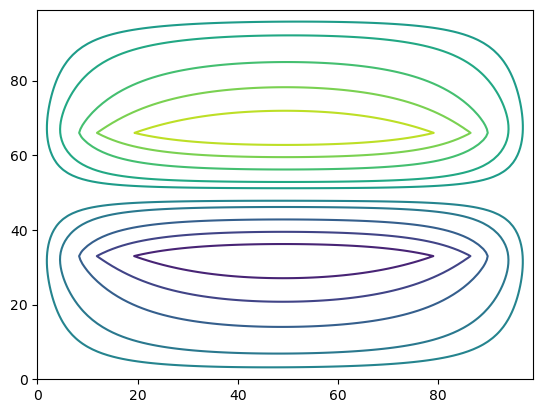

In [64]:
a = FuncAnimation(fig, func, init_func=animation.static_plot)
plt.show()
a.save('my_animation')